In [1]:
import numpy as np
import scipy as sc
from scipy import linalg
from scipy import spatial
import scipy.spatial.distance
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pylab
import json
import os


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
def rosenparse():
    with open('N02-18_GML/N02-18_RailroadSection.geojson',encoding="utf-8") as f:
        l = json.load(f)
    cd = 'rosenjson/'
    for i in l.get("features"):
        if os.path.isfile(cd+i.get('properties').get('N02_003')+'.json') == False :
            with open(cd+i.get('properties').get('N02_003')+'.json',encoding="utf-8",mode='w') as f:
                f.write('['+json.dumps(i)+']')
        else :
            with open(cd+i.get('properties').get('N02_003')+'.json',mode='ab+') as f:
                f.seek(-1,2)                           # ファイルの末尾（2）から -1 文字移動
                f.truncate()                           # 最後の文字を削除し、JSON 配列を開ける（]の削除）
                f.write(' , '.encode())                # 配列のセパレーターを書き込む
                f.write(json.dumps(i).encode())     # 辞書を JSON 形式でダンプ書き込み
                f.write(']'.encode())     
    print("finish")

In [3]:
def ekiparse():
    cd = 'rosenekijson/'
    with open('N02-18_GML/N02-18_Station.geojson',encoding="utf-8") as f:
        l = json.load(f)
    for i in l.get("features"):
        if os.path.isfile(cd+i.get('properties').get('N02_003')+'.json') == False :
            with open(cd+i.get('properties').get('N02_003')+'.json',encoding="utf-8",mode='w') as f:
                f.write('['+json.dumps(i)+']')
        else :
            with open(cd+i.get('properties').get('N02_003')+'.json',mode='ab+') as f:
                f.seek(-1,2)                           # ファイルの末尾（2）から -1 文字移動
                f.truncate()                           # 最後の文字を削除し、JSON 配列を開ける（]の削除）
                f.write(' , '.encode())                # 配列のセパレーターを書き込む
                f.write(json.dumps(i).encode())     # 辞書を JSON 形式でダンプ書き込み
                f.write(']'.encode())     
    print("finish")

In [4]:
def jidoinstance():
    cd1 ='rosenjson/'
    cd2 = 'rosenekijson/'
    for i in  os.listdir(path=cd1):
        if os.path.isfile(cd2+i) == True :
            print (i.rstrip('.json')+'=rosen("'+cd1+i+'","'+cd2+i+'")')
    

In [5]:
class rosen():
    divide = 2
    ekiData= []
    rosenData=[]
    ekiDict=[]
    rosenAvg=[0,0]
    rosenStd=[0,0]
    invR=[]
    R=[]
    x_return = []
    ekiData2=np.array([])
    div = 1000
    curve_c = np.zeros((2,div+1))
    def __init__(self, ekiurl,rosenurl):
        self.ekiurl  = ekiurl
        self.rosenurl  = rosenurl
        self.rosenMahaUrl  = "rosenmaha/"+ekiurl.lstrip('rosenjson/')
        self.ekiMahaUrl  = "ekimaha/"+ekiurl.lstrip('rosenjson/')
        self.ekiData= []
        self.rosenData= []
        self.ekiDetailData=[]
        self.ekiDict=[]
        self.rosenAvg=[0,0]
        self.rosenStd=[0,0]
        self.ekiAvg=[]
        self.ekiStd=[]
        self.ekiInvR=[]
        self.ekiInvR2=[]
        self.ekiname=[]
        self.curve_c = np.zeros((2,self.div+1))
        self. x_return =[]
        self.R = np.zeros((self.divide,self.divide))
        self.rosenInvR=np.zeros((self.divide,self.divide))
        self.ekiInvR=np.zeros((self.divide,self.divide))
        self.getData()
        self.daen()
        


    def getData(self):
        with open(self.rosenurl,encoding="utf-8") as f:
            l = json.load(f)
            for i in l:
                for j in i.get("geometry").get("coordinates"):
                    self.ekiData.append(j)
            self.ekiData2 = np.copy(self.ekiData)
        if os.path.isfile(self.rosenMahaUrl) == True :
            with open(self.rosenMahaUrl,encoding="utf-8") as f:
                l = json.load(f)
                self.rosenAvg=l.get('Avg')
                self.rosenStd=l.get('Std')
                self.rosenInvR=l.get('InvR')
        else :
            self.avg(self.rosenMahaUrl) 
        with open(self.rosenurl,encoding="utf-8") as f:
            l = json.load(f)
            self.ekiDict = l
        if os.path.isfile(self.ekiMahaUrl) == True :
            with open(self.ekiMahaUrl,encoding="utf-8") as f:
                l = json.load(f)
                x = 0
                for i in l:
                    self.ekiAvg.append(i.get('Avg'))
                    self.ekiStd.append(i.get('Std'))
                    self.ekiInvR2.append(i.get('InvR'))
                    self.ekiname.append(i.get('name'))
                    x = x + 1
        else :
            self.ekiavg(self.ekiMahaUrl) 
    def avg(self,url):
        url = url
        for i in range(self.divide):
            sumx = 0
            tmp =[]
            for j in range(len(self.ekiData)):
                tmp.append(self.ekiData[j][i])
                sumx = sumx + self.ekiData[j][i]
            self.rosenAvg[i] = sumx / len(self.ekiData)
            self.rosenStd[i] = np.std(tmp)          
        self.rosenMaha(url)
    def ekiavg(self,url):
        url = url
        for ia in range(len(self.ekiDict)):
            i = self.ekiDict[ia]
            addAvg=[]
            addStd=[]
            addlist1=[]
            addlist2=[]
            for j in range(self.divide):
                sumx = 0
                tmp =[]
                x = i.get("geometry").get("coordinates")
                for k in x :                      
                    tmp.append(k[j])
                    sumx = sumx + k[j]
                addAvg.append(sumx / len(i.get("geometry").get("coordinates")))
                tmp.append(sumx / len(i.get("geometry").get("coordinates"))- 0.0002)
                tmp.append(sumx / len(i.get("geometry").get("coordinates"))+ 0.0002)
                addlist1.append(sumx / len(i.get("geometry").get("coordinates"))- 0.0002)
                addlist2.append(sumx / len(i.get("geometry").get("coordinates"))+ 0.0002)
                ansst = np.std(tmp)
                if ansst < 0.0001:
                    ansst = 0.0001
                addStd.append(ansst) 
            self.ekiAvg.append(addAvg)
            self.ekiStd.append(addStd)
            self.ekiDict[ia].get("geometry").get("coordinates").append(addlist1)
            self.ekiDict[ia].get("geometry").get("coordinates").append(addlist2)
        self.ekiMaha(url)
    def rosenMaha(self,url):
        url= url
        x = np.copy(self.ekiData)
        for i in range(self.divide):
            for j in range(len(self.ekiData)):
                x[j][i] = x[j][i] - self.rosenAvg[i]
                x[j][i] = x[j][i] / self.rosenStd[i]
        R = np.corrcoef(x.transpose())
        self.rosenInvR = np.linalg.inv(R)
        tmp = {}
        with open(url,encoding="utf-8",mode='w' ) as f:
            tmp = {}
            tmp["Avg"] =  self.rosenAvg
            tmp["Std"]= self.rosenStd
            tmp["InvR"]= self.rosenInvR.tolist()
            tmp["name"]= self.ekiurl.lstrip('rosenjson/').rstrip('.json')
            json.dump(tmp,f)
        with open('rosenmaha/rosenmaha.json',mode='ab+' ) as f:
            f.seek(-1,2)                           # ファイルの末尾（2）から -1 文字移動
            f.truncate()                           # 最後の文字を削除し、JSON 配列を開ける（]の削除）
            f.write(' , '.encode())                # 配列のセパレーターを書き込む
            f.write(json.dumps(tmp).encode())     # 辞書を JSON 形式でダンプ書き込み
            f.write(']'.encode())  
    def ekiMaha(self,url):
        url= url
        for i in range(len(self.ekiDict)):
            j = self.ekiDict[i].get("geometry").get("coordinates")
            x = np.copy(j)
            for k in range(self.divide):
                for l in range(len(x)):
                    print(i)
                    x[l][k] = x[l][k] - self.ekiAvg[i][k]
                    if x[l][k] == 0:
                        x[l][k] = x[l][k] + 0.00002
                    x[l][k] = x[l][k] / self.ekiStd[i][k]
            R = np.corrcoef(x.transpose())
            addlist3=np.linalg.inv(R).tolist()
            self.ekiInvR2.append(addlist3)
            if i == 0:
                with open(url,encoding="utf-8",mode='x' ) as f:
                    f.write("[")
                    tmp = {}
                    tmp["Avg"] =  self.ekiAvg[i]
                    tmp["Std"]= self.ekiStd[i]
                    tmp["InvR"]= addlist3
                    tmp["name"]= self.ekiDict[i].get("properties").get("N02_005")
                    json.dump(tmp,f)
                    f.write("]")
            else:
                with open(url,mode='ab+' ) as f:
                    tmp = {}
                    tmp["Avg"] =  self.ekiAvg[i]
                    tmp["Std"]= self.ekiStd[i]
                    tmp["InvR"]= addlist3
                    tmp["name"]= self.ekiDict[i].get("properties").get("N02_005")
                    f.seek(-1,2)                           # ファイルの末尾（2）から -1 文字移動
                    f.truncate()                           # 最後の文字を削除し、JSON 配列を開ける（]の削除）
                    f.write(' , '.encode())                # 配列のセパレーターを書き込む
                    f.write(json.dumps(tmp).encode())     # 辞書を JSON 形式でダンプ書き込み
                    f.write(']'.encode())  
    def daen(self):
        low = np.corrcoef(self.ekiData2[:,0],self.ekiData2[:,1])[0,1]
        p = 0.97
        for i in range(self.div+1):
            r = (-2*(1-low**2)*np.log(1-p)/(1-2*low*np.sin(i*2*np.pi/self.div)*np.cos(i*2*np.pi/self.div)))**0.5
            self.curve_c[0,i] = self.rosenAvg[0] + self.rosenStd[0]*r*np.cos(i*2*np.pi/self.div)
            self.curve_c[1,i] = self.rosenAvg[1] + self.rosenStd[1]*r*np.sin(i*2*np.pi/self.div)
    def getRosenMaha(self,position):
        self.x_return=[]
        x = np.copy(position)
        for i in range(self.divide):
            x[i] = x[i] - self.rosenAvg[i]
            x[i] = x[i] / self.rosenStd[i]
        d0 = x
        d1 = np.dot(d0,self.rosenInvR)
        d2 = np.dot(d1,d0)/self.divide
        self.x_return.append(d2)
        return d2
    def getEki(self,position):
        lenreturn=[]
        for j in range(len(self.ekiAvg)):
            x = np.copy(position)
            for i in range(self.divide):
                x[i] = x[i] - self.ekiAvg[j][i]
                x[i] = x[i] / self.ekiStd[j][i]
            d0 = x
            d1 = np.dot(d0,self.ekiInvR)
            d2 = np.dot(d1,d0)/self.divide
            if d2 < 2.48:
                return (self.ekiDict[j].get("name"))

In [6]:
沖縄都市モノレール線=rosen("rosenjson/沖縄都市モノレール線.json","rosenekijson/沖縄都市モノレール線.json")
いわて銀河鉄道線=rosen("rosenjson/いわて銀河鉄道線.json","rosenekijson/いわて銀河鉄道線.json")
いすみ線=rosen("rosenjson/いすみ線.json","rosenekijson/いすみ線.json")
三国芦原線=rosen("rosenjson/三国芦原線.json","rosenekijson/三国芦原線.json")
勝山永平寺線=rosen("rosenjson/勝山永平寺線.json","rosenekijson/勝山永平寺線.json")
湯前線=rosen("rosenjson/湯前線.json","rosenekijson/湯前線.json")
しなの鉄道線=rosen("rosenjson/しなの鉄道線.json","rosenekijson/しなの鉄道線.json")
広島短距離交通瀬野線=rosen("rosenjson/広島短距離交通瀬野線.json","rosenekijson/広島短距離交通瀬野線.json")
七尾線=rosen("rosenjson/七尾線.json","rosenekijson/七尾線.json")
わたらせ渓谷線=rosen("rosenjson/わたらせ渓谷線.json","rosenekijson/わたらせ渓谷線.json")
阿佐東線=rosen("rosenjson/阿佐東線.json","rosenekijson/阿佐東線.json")
阿武隈急行線=rosen("rosenjson/阿武隈急行線.json","rosenekijson/阿武隈急行線.json")
愛知環状鉄道線=rosen("rosenjson/愛知環状鉄道線.json","rosenekijson/愛知環状鉄道線.json")
東部丘陵線=rosen("rosenjson/東部丘陵線.json","rosenekijson/東部丘陵線.json")
鞍馬山鋼索鉄道=rosen("rosenjson/鞍馬山鋼索鉄道.json","rosenekijson/鞍馬山鋼索鉄道.json")
伊勢線=rosen("rosenjson/伊勢線.json","rosenekijson/伊勢線.json")
伊豆急行線=rosen("rosenjson/伊豆急行線.json","rosenekijson/伊豆急行線.json")
十国鋼索線=rosen("rosenjson/十国鋼索線.json","rosenekijson/十国鋼索線.json")
駿豆線=rosen("rosenjson/駿豆線.json","rosenekijson/駿豆線.json")
大雄山線=rosen("rosenjson/大雄山線.json","rosenekijson/大雄山線.json")
横河原線=rosen("rosenjson/横河原線.json","rosenekijson/横河原線.json")
花園線=rosen("rosenjson/花園線.json","rosenekijson/花園線.json")
郡中線=rosen("rosenjson/郡中線.json","rosenekijson/郡中線.json")
高浜線=rosen("rosenjson/高浜線.json","rosenekijson/高浜線.json")
城南線=rosen("rosenjson/城南線.json","rosenekijson/城南線.json")
城北線=rosen("rosenjson/城北線.json","rosenekijson/城北線.json")
大手町線=rosen("rosenjson/大手町線.json","rosenekijson/大手町線.json")
本町線=rosen("rosenjson/本町線.json","rosenekijson/本町線.json")
井原線=rosen("rosenjson/井原線.json","rosenekijson/井原線.json")
大社線=rosen("rosenjson/大社線.json","rosenekijson/大社線.json")
北松江線=rosen("rosenjson/北松江線.json","rosenekijson/北松江線.json")
鞍馬線=rosen("rosenjson/鞍馬線.json","rosenekijson/鞍馬線.json")
叡山本線=rosen("rosenjson/叡山本線.json","rosenekijson/叡山本線.json")
鉄道線=rosen("rosenjson/鉄道線.json","rosenekijson/鉄道線.json")
みなとみらい21線=rosen("rosenjson/みなとみらい21線.json","rosenekijson/みなとみらい21線.json")
一号線=rosen("rosenjson/1号線.json","rosenekijson/1号線.json")
三号線=rosen("rosenjson/3号線.json","rosenekijson/3号線.json")
金沢シーサイドライン=rosen("rosenjson/金沢シーサイドライン.json","rosenekijson/金沢シーサイドライン.json")
清輝橋線=rosen("rosenjson/清輝橋線.json","rosenekijson/清輝橋線.json")
東山本線=rosen("rosenjson/東山本線.json","rosenekijson/東山本線.json")
会津線=rosen("rosenjson/会津線.json","rosenekijson/会津線.json")
岳南線=rosen("rosenjson/岳南線.json","rosenekijson/岳南線.json")
甘木線=rosen("rosenjson/甘木線.json","rosenekijson/甘木線.json")
常総線=rosen("rosenjson/常総線.json","rosenekijson/常総線.json")
竜ヶ崎線=rosen("rosenjson/竜ヶ崎線.json","rosenekijson/竜ヶ崎線.json")
紀州鉄道線=rosen("rosenjson/紀州鉄道線.json","rosenekijson/紀州鉄道線.json")
井の頭線=rosen("rosenjson/井の頭線.json","rosenekijson/井の頭線.json")
京王線=rosen("rosenjson/京王線.json","rosenekijson/京王線.json")
競馬場線=rosen("rosenjson/競馬場線.json","rosenekijson/競馬場線.json")
高尾線=rosen("rosenjson/高尾線.json","rosenekijson/高尾線.json")
相模原線=rosen("rosenjson/相模原線.json","rosenekijson/相模原線.json")
動物園線=rosen("rosenjson/動物園線.json","rosenekijson/動物園線.json")
宇治線=rosen("rosenjson/宇治線.json","rosenekijson/宇治線.json")
鴨東線=rosen("rosenjson/鴨東線.json","rosenekijson/鴨東線.json")
京阪本線=rosen("rosenjson/京阪本線.json","rosenekijson/京阪本線.json")
京津線=rosen("rosenjson/京津線.json","rosenekijson/京津線.json")
交野線=rosen("rosenjson/交野線.json","rosenekijson/交野線.json")
鋼索線=rosen("rosenjson/鋼索線.json","rosenekijson/鋼索線.json")
石山坂本線=rosen("rosenjson/石山坂本線.json","rosenekijson/石山坂本線.json")
押上線=rosen("rosenjson/押上線.json","rosenekijson/押上線.json")
金町線=rosen("rosenjson/金町線.json","rosenekijson/金町線.json")
千原線=rosen("rosenjson/千原線.json","rosenekijson/千原線.json")
千葉線=rosen("rosenjson/千葉線.json","rosenekijson/千葉線.json")
東成田線=rosen("rosenjson/東成田線.json","rosenekijson/東成田線.json")
本線=rosen("rosenjson/本線.json","rosenekijson/本線.json")
烏丸線=rosen("rosenjson/烏丸線.json","rosenekijson/烏丸線.json")
東西線=rosen("rosenjson/東西線.json","rosenekijson/東西線.json")
久里浜線=rosen("rosenjson/久里浜線.json","rosenekijson/久里浜線.json")
空港線=rosen("rosenjson/空港線.json","rosenekijson/空港線.json")
逗子線=rosen("rosenjson/逗子線.json","rosenekijson/逗子線.json")
大師線=rosen("rosenjson/大師線.json","rosenekijson/大師線.json")
北野線=rosen("rosenjson/北野線.json","rosenekijson/北野線.json")
嵐山本線=rosen("rosenjson/嵐山本線.json","rosenekijson/嵐山本線.json")
錦川清流線=rosen("rosenjson/錦川清流線.json","rosenekijson/錦川清流線.json")
橿原線=rosen("rosenjson/橿原線.json","rosenekijson/橿原線.json")
吉野線=rosen("rosenjson/吉野線.json","rosenekijson/吉野線.json")
京都線=rosen("rosenjson/京都線.json","rosenekijson/京都線.json")
御所線=rosen("rosenjson/御所線.json","rosenekijson/御所線.json")
山田線=rosen("rosenjson/山田線.json","rosenekijson/山田線.json")
志摩線=rosen("rosenjson/志摩線.json","rosenekijson/志摩線.json")
信貴線=rosen("rosenjson/信貴線.json","rosenekijson/信貴線.json")
生駒鋼索線=rosen("rosenjson/生駒鋼索線.json","rosenekijson/生駒鋼索線.json")
生駒線=rosen("rosenjson/生駒線.json","rosenekijson/生駒線.json")
西信貴鋼索線=rosen("rosenjson/西信貴鋼索線.json","rosenekijson/西信貴鋼索線.json")
大阪線=rosen("rosenjson/大阪線.json","rosenekijson/大阪線.json")
長野線=rosen("rosenjson/長野線.json","rosenekijson/長野線.json")
鳥羽線=rosen("rosenjson/鳥羽線.json","rosenekijson/鳥羽線.json")
天理線=rosen("rosenjson/天理線.json","rosenekijson/天理線.json")
田原本線=rosen("rosenjson/田原本線.json","rosenekijson/田原本線.json")
湯の山線=rosen("rosenjson/湯の山線.json","rosenekijson/湯の山線.json")
道明寺線=rosen("rosenjson/道明寺線.json","rosenekijson/道明寺線.json")
奈良線=rosen("rosenjson/奈良線.json","rosenekijson/奈良線.json")
内部線=rosen("rosenjson/内部線.json","rosenekijson/内部線.json")
南大阪線=rosen("rosenjson/南大阪線.json","rosenekijson/南大阪線.json")
難波線=rosen("rosenjson/難波線.json","rosenekijson/難波線.json")
阪神なんば線=rosen("rosenjson/阪神なんば線.json","rosenekijson/阪神なんば線.json")
八王子線=rosen("rosenjson/八王子線.json","rosenekijson/八王子線.json")
名古屋線=rosen("rosenjson/名古屋線.json","rosenekijson/名古屋線.json")
鈴鹿線=rosen("rosenjson/鈴鹿線.json","rosenekijson/鈴鹿線.json")
多賀線=rosen("rosenjson/多賀線.json","rosenekijson/多賀線.json")
八日市線=rosen("rosenjson/八日市線.json","rosenekijson/八日市線.json")
吉都線=rosen("rosenjson/吉都線.json","rosenekijson/吉都線.json")
久大線=rosen("rosenjson/久大線.json","rosenekijson/久大線.json")
宮崎空港線=rosen("rosenjson/宮崎空港線.json","rosenekijson/宮崎空港線.json")
九州新幹線=rosen("rosenjson/九州新幹線.json","rosenekijson/九州新幹線.json")
後藤寺線=rosen("rosenjson/後藤寺線.json","rosenekijson/後藤寺線.json")
香椎線=rosen("rosenjson/香椎線.json","rosenekijson/香椎線.json")
佐世保線=rosen("rosenjson/佐世保線.json","rosenekijson/佐世保線.json")
三角線=rosen("rosenjson/三角線.json","rosenekijson/三角線.json")
山陽線=rosen("rosenjson/山陽線.json","rosenekijson/山陽線.json")
指宿枕崎線=rosen("rosenjson/指宿枕崎線.json","rosenekijson/指宿枕崎線.json")
鹿児島線=rosen("rosenjson/鹿児島線.json","rosenekijson/鹿児島線.json")
篠栗線=rosen("rosenjson/篠栗線.json","rosenekijson/篠栗線.json")
大村線=rosen("rosenjson/大村線.json","rosenekijson/大村線.json")
筑肥線=rosen("rosenjson/筑肥線.json","rosenekijson/筑肥線.json")
筑豊線=rosen("rosenjson/筑豊線.json","rosenekijson/筑豊線.json")
長崎線=rosen("rosenjson/長崎線.json","rosenekijson/長崎線.json")
唐津線=rosen("rosenjson/唐津線.json","rosenekijson/唐津線.json")
日田彦山線=rosen("rosenjson/日田彦山線.json","rosenekijson/日田彦山線.json")
日南線=rosen("rosenjson/日南線.json","rosenekijson/日南線.json")
日豊線=rosen("rosenjson/日豊線.json","rosenekijson/日豊線.json")
肥薩線=rosen("rosenjson/肥薩線.json","rosenekijson/肥薩線.json")
豊肥線=rosen("rosenjson/豊肥線.json","rosenekijson/豊肥線.json")
幹線=rosen("rosenjson/幹線.json","rosenekijson/幹線.json")
健軍線=rosen("rosenjson/健軍線.json","rosenekijson/健軍線.json")
上熊本線=rosen("rosenjson/上熊本線.json","rosenekijson/上熊本線.json")
水前寺線=rosen("rosenjson/水前寺線.json","rosenekijson/水前寺線.json")
田崎線=rosen("rosenjson/田崎線.json","rosenekijson/田崎線.json")
菊池線=rosen("rosenjson/菊池線.json","rosenekijson/菊池線.json")
藤崎線=rosen("rosenjson/藤崎線.json","rosenekijson/藤崎線.json")
ケーブルカー=rosen("rosenjson/ケーブルカー.json","rosenekijson/ケーブルカー.json")
広島新交通1号線=rosen("rosenjson/広島新交通1号線.json","rosenekijson/広島新交通1号線.json")
宇品線=rosen("rosenjson/宇品線.json","rosenekijson/宇品線.json")
横川線=rosen("rosenjson/横川線.json","rosenekijson/横川線.json")
皆実線=rosen("rosenjson/皆実線.json","rosenekijson/皆実線.json")
宮島線=rosen("rosenjson/宮島線.json","rosenekijson/宮島線.json")
江波線=rosen("rosenjson/江波線.json","rosenekijson/江波線.json")
白島線=rosen("rosenjson/白島線.json","rosenekijson/白島線.json")
弘南線=rosen("rosenjson/弘南線.json","rosenekijson/弘南線.json")
大鰐線=rosen("rosenjson/大鰐線.json","rosenekijson/大鰐線.json")
江ノ島電鉄線=rosen("rosenjson/江ノ島電鉄線.json","rosenekijson/江ノ島電鉄線.json")
琴平線=rosen("rosenjson/琴平線.json","rosenekijson/琴平線.json")
志度線=rosen("rosenjson/志度線.json","rosenekijson/志度線.json")
長尾線=rosen("rosenjson/長尾線.json","rosenekijson/長尾線.json")
高尾鋼索線=rosen("rosenjson/高尾鋼索線.json","rosenekijson/高尾鋼索線.json")
嵯峨野観光線=rosen("rosenjson/嵯峨野観光線.json","rosenekijson/嵯峨野観光線.json")
伊丹線=rosen("rosenjson/伊丹線.json","rosenekijson/伊丹線.json")
甲陽線=rosen("rosenjson/甲陽線.json","rosenekijson/甲陽線.json")
今津線=rosen("rosenjson/今津線.json","rosenekijson/今津線.json")
神戸高速線=rosen("rosenjson/神戸高速線.json","rosenekijson/神戸高速線.json")
神戸線=rosen("rosenjson/神戸線.json","rosenekijson/神戸線.json")
千里線=rosen("rosenjson/千里線.json","rosenekijson/千里線.json")
宝塚線=rosen("rosenjson/宝塚線.json","rosenekijson/宝塚線.json")
箕面線=rosen("rosenjson/箕面線.json","rosenekijson/箕面線.json")
嵐山線=rosen("rosenjson/嵐山線.json","rosenekijson/嵐山線.json")
阪堺線=rosen("rosenjson/阪堺線.json","rosenekijson/阪堺線.json")
上町線=rosen("rosenjson/上町線.json","rosenekijson/上町線.json")
武庫川線=rosen("rosenjson/武庫川線.json","rosenekijson/武庫川線.json")
埼玉高速鉄道線=rosen("rosenjson/埼玉高速鉄道線.json","rosenekijson/埼玉高速鉄道線.json")
伊奈線=rosen("rosenjson/伊奈線.json","rosenekijson/伊奈線.json")
一条線=rosen("rosenjson/1条線.json","rosenekijson/1条線.json")
山鼻西線=rosen("rosenjson/山鼻西線.json","rosenekijson/山鼻西線.json")
山鼻線=rosen("rosenjson/山鼻線.json","rosenekijson/山鼻線.json")
東豊線=rosen("rosenjson/東豊線.json","rosenekijson/東豊線.json")
南北線=rosen("rosenjson/南北線.json","rosenekijson/南北線.json")
近鉄連絡線=rosen("rosenjson/近鉄連絡線.json","rosenekijson/近鉄連絡線.json")
三岐線=rosen("rosenjson/三岐線.json","rosenekijson/三岐線.json")
北勢線=rosen("rosenjson/北勢線.json","rosenekijson/北勢線.json")
南リアス線=rosen("rosenjson/南リアス線.json","rosenekijson/南リアス線.json")
北リアス線=rosen("rosenjson/北リアス線.json","rosenekijson/北リアス線.json")
フラワー長井線=rosen("rosenjson/フラワー長井線.json","rosenekijson/フラワー長井線.json")
ユーカリが丘線=rosen("rosenjson/ユーカリが丘線.json","rosenekijson/ユーカリが丘線.json")
網干線=rosen("rosenjson/網干線.json","rosenekijson/網干線.json")
八栗ケーブル=rosen("rosenjson/八栗ケーブル.json","rosenekijson/八栗ケーブル.json")
高徳線=rosen("rosenjson/高徳線.json","rosenekijson/高徳線.json")
土讃線=rosen("rosenjson/土讃線.json","rosenekijson/土讃線.json")
徳島線=rosen("rosenjson/徳島線.json","rosenekijson/徳島線.json")
内子線=rosen("rosenjson/内子線.json","rosenekijson/内子線.json")
本四備讃線=rosen("rosenjson/本四備讃線.json","rosenekijson/本四備讃線.json")
牟岐線=rosen("rosenjson/牟岐線.json","rosenekijson/牟岐線.json")
鳴門線=rosen("rosenjson/鳴門線.json","rosenekijson/鳴門線.json")
予讃線=rosen("rosenjson/予讃線.json","rosenekijson/予讃線.json")
予土線=rosen("rosenjson/予土線.json","rosenekijson/予土線.json")
第一期線=rosen("rosenjson/第一期線.json","rosenekijson/第一期線.json")
第二期線=rosen("rosenjson/第二期線.json","rosenekijson/第二期線.json")
谷山線=rosen("rosenjson/谷山線.json","rosenekijson/谷山線.json")
唐湊線=rosen("rosenjson/唐湊線.json","rosenekijson/唐湊線.json")
大洗鹿島線=rosen("rosenjson/大洗鹿島線.json","rosenekijson/大洗鹿島線.json")
芝山鉄道線=rosen("rosenjson/芝山鉄道線.json","rosenekijson/芝山鉄道線.json")
若桜線=rosen("rosenjson/若桜線.json","rosenekijson/若桜線.json")
常磐新線=rosen("rosenjson/常磐新線.json","rosenekijson/常磐新線.json")
秋田内陸線=rosen("rosenjson/秋田内陸線.json","rosenekijson/秋田内陸線.json")
江ノ島線=rosen("rosenjson/江ノ島線.json","rosenekijson/江ノ島線.json")
小田原線=rosen("rosenjson/小田原線.json","rosenekijson/小田原線.json")
多摩線=rosen("rosenjson/多摩線.json","rosenekijson/多摩線.json")
小湊鐵道線=rosen("rosenjson/小湊鐵道線.json","rosenekijson/小湊鐵道線.json")
西九州線=rosen("rosenjson/西九州線.json","rosenekijson/西九州線.json")
上高地線=rosen("rosenjson/上高地線.json","rosenekijson/上高地線.json")
江の島線=rosen("rosenjson/江の島線.json","rosenekijson/江の島線.json")
上信線=rosen("rosenjson/上信線.json","rosenekijson/上信線.json")
別所線=rosen("rosenjson/別所線.json","rosenekijson/別所線.json")
上毛線=rosen("rosenjson/上毛線.json","rosenekijson/上毛線.json")
信楽線=rosen("rosenjson/信楽線.json","rosenekijson/信楽線.json")
新京成線=rosen("rosenjson/新京成線.json","rosenekijson/新京成線.json")
真岡線=rosen("rosenjson/真岡線.json","rosenekijson/真岡線.json")
海岸線=rosen("rosenjson/海岸線.json","rosenekijson/海岸線.json")
山手線=rosen("rosenjson/山手線.json","rosenekijson/山手線.json")
西神延伸線=rosen("rosenjson/西神延伸線.json","rosenekijson/西神延伸線.json")
西神線=rosen("rosenjson/西神線.json","rosenekijson/西神線.json")
摩耶ケーブル線=rosen("rosenjson/摩耶ケーブル線.json","rosenekijson/摩耶ケーブル線.json")
六甲アイランド線=rosen("rosenjson/六甲アイランド線.json","rosenekijson/六甲アイランド線.json")
粟生線=rosen("rosenjson/粟生線.json","rosenekijson/粟生線.json")
公園都市線=rosen("rosenjson/公園都市線.json","rosenekijson/公園都市線.json")
三田線=rosen("rosenjson/三田線.json","rosenekijson/三田線.json")
有馬線=rosen("rosenjson/有馬線.json","rosenekijson/有馬線.json")
水間線=rosen("rosenjson/水間線.json","rosenekijson/水間線.json")
水島本線=rosen("rosenjson/水島本線.json","rosenekijson/水島本線.json")
貝塚線=rosen("rosenjson/貝塚線.json","rosenekijson/貝塚線.json")
太宰府線=rosen("rosenjson/太宰府線.json","rosenekijson/太宰府線.json")
天神大牟田線=rosen("rosenjson/天神大牟田線.json","rosenekijson/天神大牟田線.json")
JR東西線=rosen("rosenjson/JR東西線.json","rosenekijson/JR東西線.json")
因美線=rosen("rosenjson/因美線.json","rosenekijson/因美線.json")
宇部線=rosen("rosenjson/宇部線.json","rosenekijson/宇部線.json")
宇野線=rosen("rosenjson/宇野線.json","rosenekijson/宇野線.json")
越美北線=rosen("rosenjson/越美北線.json","rosenekijson/越美北線.json")
加古川線=rosen("rosenjson/加古川線.json","rosenekijson/加古川線.json")
可部線=rosen("rosenjson/可部線.json","rosenekijson/可部線.json")
関西空港線=rosen("rosenjson/関西空港線.json","rosenekijson/関西空港線.json")
関西線=rosen("rosenjson/関西線.json","rosenekijson/関西線.json")
岩徳線=rosen("rosenjson/岩徳線.json","rosenekijson/岩徳線.json")
紀勢線=rosen("rosenjson/紀勢線.json","rosenekijson/紀勢線.json")
吉備線=rosen("rosenjson/吉備線.json","rosenekijson/吉備線.json")
境線=rosen("rosenjson/境線.json","rosenekijson/境線.json")
芸備線=rosen("rosenjson/芸備線.json","rosenekijson/芸備線.json")
湖西線=rosen("rosenjson/湖西線.json","rosenekijson/湖西線.json")
呉線=rosen("rosenjson/呉線.json","rosenekijson/呉線.json")
高山線=rosen("rosenjson/高山線.json","rosenekijson/高山線.json")
阪和線=rosen("rosenjson/阪和線.json","rosenekijson/阪和線.json")
桜井線=rosen("rosenjson/桜井線.json","rosenekijson/桜井線.json")
桜島線=rosen("rosenjson/桜島線.json","rosenekijson/桜島線.json")
山陰線=rosen("rosenjson/山陰線.json","rosenekijson/山陰線.json")
山口線=rosen("rosenjson/山口線.json","rosenekijson/山口線.json")
山陽新幹線=rosen("rosenjson/山陽新幹線.json","rosenekijson/山陽新幹線.json")
小浜線=rosen("rosenjson/小浜線.json","rosenekijson/小浜線.json")
小野田線=rosen("rosenjson/小野田線.json","rosenekijson/小野田線.json")
城端線=rosen("rosenjson/城端線.json","rosenekijson/城端線.json")
赤穂線=rosen("rosenjson/赤穂線.json","rosenekijson/赤穂線.json")
草津線=rosen("rosenjson/草津線.json","rosenekijson/草津線.json")
大阪環状線=rosen("rosenjson/大阪環状線.json","rosenekijson/大阪環状線.json")
大糸線=rosen("rosenjson/大糸線.json","rosenekijson/大糸線.json")
津山線=rosen("rosenjson/津山線.json","rosenekijson/津山線.json")
東海道線=rosen("rosenjson/東海道線.json","rosenekijson/東海道線.json")
播但線=rosen("rosenjson/播但線.json","rosenekijson/播但線.json")
伯備線=rosen("rosenjson/伯備線.json","rosenekijson/伯備線.json")
博多南線=rosen("rosenjson/博多南線.json","rosenekijson/博多南線.json")
美祢線=rosen("rosenjson/美祢線.json","rosenekijson/美祢線.json")
姫新線=rosen("rosenjson/姫新線.json","rosenekijson/姫新線.json")
氷見線=rosen("rosenjson/氷見線.json","rosenekijson/氷見線.json")
舞鶴線=rosen("rosenjson/舞鶴線.json","rosenekijson/舞鶴線.json")
福塩線=rosen("rosenjson/福塩線.json","rosenekijson/福塩線.json")
福知山線=rosen("rosenjson/福知山線.json","rosenekijson/福知山線.json")
片町線=rosen("rosenjson/片町線.json","rosenekijson/片町線.json")
日本海ひすいライン=rosen("rosenjson/日本海ひすいライン.json","rosenekijson/日本海ひすいライン.json")
妙高はねうまライン=rosen("rosenjson/妙高はねうまライン.json","rosenekijson/妙高はねうまライン.json")
あいの風とやま鉄道線=rosen("rosenjson/あいの風とやま鉄道線.json","rosenekijson/あいの風とやま鉄道線.json")
IRいしかわ鉄道線=rosen("rosenjson/IRいしかわ鉄道線.json","rosenekijson/IRいしかわ鉄道線.json")
北陸線=rosen("rosenjson/北陸線.json","rosenekijson/北陸線.json")
木次線=rosen("rosenjson/木次線.json","rosenekijson/木次線.json")
和歌山線=rosen("rosenjson/和歌山線.json","rosenekijson/和歌山線.json")
狭山線=rosen("rosenjson/狭山線.json","rosenekijson/狭山線.json")
国分寺線=rosen("rosenjson/国分寺線.json","rosenekijson/国分寺線.json")
新宿線=rosen("rosenjson/新宿線.json","rosenekijson/新宿線.json")
西武園線=rosen("rosenjson/西武園線.json","rosenekijson/西武園線.json")
西武秩父線=rosen("rosenjson/西武秩父線.json","rosenekijson/西武秩父線.json")
西武有楽町線=rosen("rosenjson/西武有楽町線.json","rosenekijson/西武有楽町線.json")
多摩湖線=rosen("rosenjson/多摩湖線.json","rosenekijson/多摩湖線.json")
多摩川線=rosen("rosenjson/多摩川線.json","rosenekijson/多摩川線.json")
池袋線=rosen("rosenjson/池袋線.json","rosenekijson/池袋線.json")
拝島線=rosen("rosenjson/拝島線.json","rosenekijson/拝島線.json")
豊島線=rosen("rosenjson/豊島線.json","rosenekijson/豊島線.json")
青い森鉄道線=rosen("rosenjson/青い森鉄道線.json","rosenekijson/青い森鉄道線.json")
静岡清水線=rosen("rosenjson/静岡清水線.json","rosenekijson/静岡清水線.json")
二号線=rosen("rosenjson/2号線.json","rosenekijson/2号線.json")
いずみ野線=rosen("rosenjson/いずみ野線.json","rosenekijson/いずみ野線.json")
流山線=rosen("rosenjson/流山線.json","rosenekijson/流山線.json")
多摩都市モノレール線=rosen("rosenjson/多摩都市モノレール線.json","rosenekijson/多摩都市モノレール線.json")
井川線=rosen("rosenjson/井川線.json","rosenekijson/井川線.json")
大井川本線=rosen("rosenjson/大井川本線.json","rosenekijson/大井川本線.json")
国際文化公園都市モノレール線_彩都線=rosen("rosenjson/国際文化公園都市モノレール線（彩都線）.json","rosenekijson/国際文化公園都市モノレール線（彩都線）.json")
大阪モノレール線=rosen("rosenjson/大阪モノレール線.json","rosenekijson/大阪モノレール線.json")
一号線_御堂筋線=rosen("rosenjson/1号線(御堂筋線).json","rosenekijson/1号線(御堂筋線).json")
二号線_谷町線=rosen("rosenjson/2号線(谷町線).json","rosenekijson/2号線(谷町線).json")
三号線_四つ橋線=rosen("rosenjson/3号線(四つ橋線).json","rosenekijson/3号線(四つ橋線).json")
四号線_中央線=rosen("rosenjson/4号線(中央線).json","rosenekijson/4号線(中央線).json")
五号線_千日前線=rosen("rosenjson/5号線(千日前線).json","rosenekijson/5号線(千日前線).json")
六号線_堺筋線=rosen("rosenjson/6号線(堺筋線).json","rosenekijson/6号線(堺筋線).json")
七号線_長堀鶴見緑地線=rosen("rosenjson/7号線(長堀鶴見緑地線).json","rosenekijson/7号線(長堀鶴見緑地線).json")
南港ポートタウン線=rosen("rosenjson/南港ポートタウン線.json","rosenekijson/南港ポートタウン線.json")
泉北高速鉄道線=rosen("rosenjson/泉北高速鉄道線.json","rosenekijson/泉北高速鉄道線.json")
大山鋼索線=rosen("rosenjson/大山鋼索線.json","rosenekijson/大山鋼索線.json")
樽見線=rosen("rosenjson/樽見線.json","rosenekijson/樽見線.json")
天橋立鋼索鉄道=rosen("rosenjson/天橋立鋼索鉄道.json","rosenekijson/天橋立鋼索鉄道.json")
智頭線=rosen("rosenjson/智頭線.json","rosenekijson/智頭線.json")
筑波山鋼索鉄道線=rosen("rosenjson/筑波山鋼索鉄道線.json","rosenekijson/筑波山鋼索鉄道線.json")
筑豊電気鉄道線=rosen("rosenjson/筑豊電気鉄道線.json","rosenekijson/筑豊電気鉄道線.json")
秩父本線=rosen("rosenjson/秩父本線.json","rosenekijson/秩父本線.json")
銚子電気鉄道線=rosen("rosenjson/銚子電気鉄道線.json","rosenekijson/銚子電気鉄道線.json")
蛍茶屋支線=rosen("rosenjson/蛍茶屋支線.json","rosenekijson/蛍茶屋支線.json")
桜町支線=rosen("rosenjson/桜町支線.json","rosenekijson/桜町支線.json")
赤迫支線=rosen("rosenjson/赤迫支線.json","rosenekijson/赤迫支線.json")
大浦支線=rosen("rosenjson/大浦支線.json","rosenekijson/大浦支線.json")
越美南線=rosen("rosenjson/越美南線.json","rosenekijson/越美南線.json")
津軽鉄道線=rosen("rosenjson/津軽鉄道線.json","rosenekijson/津軽鉄道線.json")
天竜浜名湖線=rosen("rosenjson/天竜浜名湖線.json","rosenekijson/天竜浜名湖線.json")
阿佐線=rosen("rosenjson/阿佐線.json","rosenekijson/阿佐線.json")
宿毛線=rosen("rosenjson/宿毛線.json","rosenekijson/宿毛線.json")
中村線=rosen("rosenjson/中村線.json","rosenekijson/中村線.json")
伊野線=rosen("rosenjson/伊野線.json","rosenekijson/伊野線.json")
後免線=rosen("rosenjson/後免線.json","rosenekijson/後免線.json")
桟橋線=rosen("rosenjson/桟橋線.json","rosenekijson/桟橋線.json")
駅前線=rosen("rosenjson/駅前線.json","rosenekijson/駅前線.json")
島原鉄道線=rosen("rosenjson/島原鉄道線.json","rosenekijson/島原鉄道線.json")
御殿場線=rosen("rosenjson/御殿場線.json","rosenekijson/御殿場線.json")
参宮線=rosen("rosenjson/参宮線.json","rosenekijson/参宮線.json")
身延線=rosen("rosenjson/身延線.json","rosenekijson/身延線.json")
太多線=rosen("rosenjson/太多線.json","rosenekijson/太多線.json")
中央線=rosen("rosenjson/中央線.json","rosenekijson/中央線.json")
東海道新幹線=rosen("rosenjson/東海道新幹線.json","rosenekijson/東海道新幹線.json")
飯田線=rosen("rosenjson/飯田線.json","rosenekijson/飯田線.json")
武豊線=rosen("rosenjson/武豊線.json","rosenekijson/武豊線.json")
名松線=rosen("rosenjson/名松線.json","rosenekijson/名松線.json")
東京モノレール羽田線=rosen("rosenjson/東京モノレール羽田線.json","rosenekijson/東京モノレール羽田線.json")
こどもの国線=rosen("rosenjson/こどもの国線.json","rosenekijson/こどもの国線.json")
世田谷線=rosen("rosenjson/世田谷線.json","rosenekijson/世田谷線.json")
大井町線=rosen("rosenjson/大井町線.json","rosenekijson/大井町線.json")
池上線=rosen("rosenjson/池上線.json","rosenekijson/池上線.json")
田園都市線=rosen("rosenjson/田園都市線.json","rosenekijson/田園都市線.json")
東横線=rosen("rosenjson/東横線.json","rosenekijson/東横線.json")
東急多摩川線=rosen("rosenjson/東急多摩川線.json","rosenekijson/東急多摩川線.json")
目黒線=rosen("rosenjson/目黒線.json","rosenekijson/目黒線.json")
二号線日比谷線=rosen("rosenjson/2号線日比谷線.json","rosenekijson/2号線日比谷線.json")
三号線銀座線=rosen("rosenjson/3号線銀座線.json","rosenekijson/3号線銀座線.json")
四号線丸ノ内線=rosen("rosenjson/4号線丸ノ内線.json","rosenekijson/4号線丸ノ内線.json")
四号線丸ノ内線分岐線=rosen("rosenjson/4号線丸ノ内線分岐線.json","rosenekijson/4号線丸ノ内線分岐線.json")
五号線東西線=rosen("rosenjson/5号線東西線.json","rosenekijson/5号線東西線.json")
七号線南北線=rosen("rosenjson/7号線南北線.json","rosenekijson/7号線南北線.json")
八号線有楽町線=rosen("rosenjson/8号線有楽町線.json","rosenekijson/8号線有楽町線.json")
十三号線副都心線=rosen("rosenjson/13号線副都心線.json","rosenekijson/13号線副都心線.json")
九号線千代田線=rosen("rosenjson/9号線千代田線.json","rosenekijson/9号線千代田線.json")
十一号線半蔵門線=rosen("rosenjson/11号線半蔵門線.json","rosenekijson/11号線半蔵門線.json")
一号線浅草線=rosen("rosenjson/1号線浅草線.json","rosenekijson/1号線浅草線.json")
六号線三田線=rosen("rosenjson/6号線三田線.json","rosenekijson/6号線三田線.json")
十号線新宿線=rosen("rosenjson/10号線新宿線.json","rosenekijson/10号線新宿線.json")
十二号線大江戸線=rosen("rosenjson/12号線大江戸線.json","rosenekijson/12号線大江戸線.json")
荒川線=rosen("rosenjson/荒川線.json","rosenekijson/荒川線.json")
上野懸垂線=rosen("rosenjson/上野懸垂線.json","rosenekijson/上野懸垂線.json")
りんかい線=rosen("rosenjson/りんかい線.json","rosenekijson/りんかい線.json")
伊東線=rosen("rosenjson/伊東線.json","rosenekijson/伊東線.json")
烏山線=rosen("rosenjson/烏山線.json","rosenekijson/烏山線.json")
羽越線=rosen("rosenjson/羽越線.json","rosenekijson/羽越線.json")
越後線=rosen("rosenjson/越後線.json","rosenekijson/越後線.json")
奥羽線=rosen("rosenjson/奥羽線.json","rosenekijson/奥羽線.json")
横須賀線=rosen("rosenjson/横須賀線.json","rosenekijson/横須賀線.json")
横浜線=rosen("rosenjson/横浜線.json","rosenekijson/横浜線.json")
花輪線=rosen("rosenjson/花輪線.json","rosenekijson/花輪線.json")
外房線=rosen("rosenjson/外房線.json","rosenekijson/外房線.json")
釜石線=rosen("rosenjson/釜石線.json","rosenekijson/釜石線.json")
気仙沼線=rosen("rosenjson/気仙沼線.json","rosenekijson/気仙沼線.json")
久留里線=rosen("rosenjson/久留里線.json","rosenekijson/久留里線.json")
京葉線=rosen("rosenjson/京葉線.json","rosenekijson/京葉線.json")
五日市線=rosen("rosenjson/五日市線.json","rosenekijson/五日市線.json")
五能線=rosen("rosenjson/五能線.json","rosenekijson/五能線.json")
吾妻線=rosen("rosenjson/吾妻線.json","rosenekijson/吾妻線.json")
高崎線=rosen("rosenjson/高崎線.json","rosenekijson/高崎線.json")
根岸線=rosen("rosenjson/根岸線.json","rosenekijson/根岸線.json")
左沢線=rosen("rosenjson/左沢線.json","rosenekijson/左沢線.json")
鹿島線=rosen("rosenjson/鹿島線.json","rosenekijson/鹿島線.json")
篠ノ井線=rosen("rosenjson/篠ノ井線.json","rosenekijson/篠ノ井線.json")
小海線=rosen("rosenjson/小海線.json","rosenekijson/小海線.json")
上越新幹線=rosen("rosenjson/上越新幹線.json","rosenekijson/上越新幹線.json")
上越線=rosen("rosenjson/上越線.json","rosenekijson/上越線.json")
常磐線=rosen("rosenjson/常磐線.json","rosenekijson/常磐線.json")
信越線=rosen("rosenjson/信越線.json","rosenekijson/信越線.json")
北しなの線=rosen("rosenjson/北しなの線.json","rosenekijson/北しなの線.json")
水郡線=rosen("rosenjson/水郡線.json","rosenekijson/水郡線.json")
水戸線=rosen("rosenjson/水戸線.json","rosenekijson/水戸線.json")
成田線=rosen("rosenjson/成田線.json","rosenekijson/成田線.json")
青梅線=rosen("rosenjson/青梅線.json","rosenekijson/青梅線.json")
石巻線=rosen("rosenjson/石巻線.json","rosenekijson/石巻線.json")
赤羽線_埼京線=rosen("rosenjson/赤羽線（埼京線）.json","rosenekijson/赤羽線（埼京線）.json")
仙山線=rosen("rosenjson/仙山線.json","rosenekijson/仙山線.json")
仙石線=rosen("rosenjson/仙石線.json","rosenekijson/仙石線.json")
川越線=rosen("rosenjson/川越線.json","rosenekijson/川越線.json")
相模線=rosen("rosenjson/相模線.json","rosenekijson/相模線.json")
総武線=rosen("rosenjson/総武線.json","rosenekijson/総武線.json")
大船渡線=rosen("rosenjson/大船渡線.json","rosenekijson/大船渡線.json")
大湊線=rosen("rosenjson/大湊線.json","rosenekijson/大湊線.json")
只見線=rosen("rosenjson/只見線.json","rosenekijson/只見線.json")
男鹿線=rosen("rosenjson/男鹿線.json","rosenekijson/男鹿線.json")
津軽線=rosen("rosenjson/津軽線.json","rosenekijson/津軽線.json")
鶴見線=rosen("rosenjson/鶴見線.json","rosenekijson/鶴見線.json")
田沢湖線=rosen("rosenjson/田沢湖線.json","rosenekijson/田沢湖線.json")
東金線=rosen("rosenjson/東金線.json","rosenekijson/東金線.json")
東北新幹線=rosen("rosenjson/東北新幹線.json","rosenekijson/東北新幹線.json")
東北線=rosen("rosenjson/東北線.json","rosenekijson/東北線.json")
東北線_埼京線=rosen("rosenjson/東北線（埼京線）.json","rosenekijson/東北線（埼京線）.json")
内房線=rosen("rosenjson/内房線.json","rosenekijson/内房線.json")
南武線=rosen("rosenjson/南武線.json","rosenekijson/南武線.json")
日光線=rosen("rosenjson/日光線.json","rosenekijson/日光線.json")
白新線=rosen("rosenjson/白新線.json","rosenekijson/白新線.json")
八戸線=rosen("rosenjson/八戸線.json","rosenekijson/八戸線.json")
八高線=rosen("rosenjson/八高線.json","rosenekijson/八高線.json")
飯山線=rosen("rosenjson/飯山線.json","rosenekijson/飯山線.json")
磐越西線=rosen("rosenjson/磐越西線.json","rosenekijson/磐越西線.json")
磐越東線=rosen("rosenjson/磐越東線.json","rosenekijson/磐越東線.json")
武蔵野線=rosen("rosenjson/武蔵野線.json","rosenekijson/武蔵野線.json")
米坂線=rosen("rosenjson/米坂線.json","rosenekijson/米坂線.json")
北上線=rosen("rosenjson/北上線.json","rosenekijson/北上線.json")
北陸新幹線=rosen("rosenjson/北陸新幹線.json","rosenekijson/北陸新幹線.json")
弥彦線=rosen("rosenjson/弥彦線.json","rosenekijson/弥彦線.json")
陸羽西線=rosen("rosenjson/陸羽西線.json","rosenekijson/陸羽西線.json")
陸羽東線=rosen("rosenjson/陸羽東線.json","rosenekijson/陸羽東線.json")
両毛線=rosen("rosenjson/両毛線.json","rosenekijson/両毛線.json")
伊勢崎線=rosen("rosenjson/伊勢崎線.json","rosenekijson/伊勢崎線.json")
宇都宮線=rosen("rosenjson/宇都宮線.json","rosenekijson/宇都宮線.json")
越生線=rosen("rosenjson/越生線.json","rosenekijson/越生線.json")
鬼怒川線=rosen("rosenjson/鬼怒川線.json","rosenekijson/鬼怒川線.json")
亀戸線=rosen("rosenjson/亀戸線.json","rosenekijson/亀戸線.json")
桐生線=rosen("rosenjson/桐生線.json","rosenekijson/桐生線.json")
佐野線=rosen("rosenjson/佐野線.json","rosenekijson/佐野線.json")
小泉線=rosen("rosenjson/小泉線.json","rosenekijson/小泉線.json")
東上本線=rosen("rosenjson/東上本線.json","rosenekijson/東上本線.json")
野田線=rosen("rosenjson/野田線.json","rosenekijson/野田線.json")
東葉高速線=rosen("rosenjson/東葉高速線.json","rosenekijson/東葉高速線.json")
高森線=rosen("rosenjson/高森線.json","rosenekijson/高森線.json")
加太線=rosen("rosenjson/加太線.json","rosenekijson/加太線.json")
高師浜線=rosen("rosenjson/高師浜線.json","rosenekijson/高師浜線.json")
高野線=rosen("rosenjson/高野線.json","rosenekijson/高野線.json")
多奈川線=rosen("rosenjson/多奈川線.json","rosenekijson/多奈川線.json")
南海本線=rosen("rosenjson/南海本線.json","rosenekijson/南海本線.json")
和歌山港線=rosen("rosenjson/和歌山港線.json","rosenekijson/和歌山港線.json")
日生線=rosen("rosenjson/日生線.json","rosenekijson/日生線.json")
妙見線=rosen("rosenjson/妙見線.json","rosenekijson/妙見線.json")
大森線=rosen("rosenjson/大森線.json","rosenekijson/大森線.json")
湯の川線=rosen("rosenjson/湯の川線.json","rosenekijson/湯の川線.json")
宝来谷地頭線=rosen("rosenjson/宝来・谷地頭線.json","rosenekijson/宝来・谷地頭線.json")
皿倉山ケーブルカー=rosen("rosenjson/皿倉山ケーブルカー.json","rosenekijson/皿倉山ケーブルカー.json")
比叡山鉄道線=rosen("rosenjson/比叡山鉄道線.json","rosenekijson/比叡山鉄道線.json")
肥薩おれんじ鉄道線=rosen("rosenjson/肥薩おれんじ鉄道線.json","rosenekijson/肥薩おれんじ鉄道線.json")
安野屋線=rosen("rosenjson/安野屋線.json","rosenekijson/安野屋線.json")
呉羽線=rosen("rosenjson/呉羽線.json","rosenekijson/呉羽線.json")
支線=rosen("rosenjson/支線.json","rosenekijson/支線.json")
上滝線=rosen("rosenjson/上滝線.json","rosenekijson/上滝線.json")
不二越線=rosen("rosenjson/不二越線.json","rosenekijson/不二越線.json")
立山線=rosen("rosenjson/立山線.json","rosenekijson/立山線.json")
河口湖線=rosen("rosenjson/河口湖線.json","rosenekijson/河口湖線.json")
大月線=rosen("rosenjson/大月線.json","rosenekijson/大月線.json")
ディズニーリゾートライン=rosen("rosenjson/ディズニーリゾートライン.json","rosenekijson/ディズニーリゾートライン.json")
福武線=rosen("rosenjson/福武線.json","rosenekijson/福武線.json")
一号線_空港線=rosen("rosenjson/1号線(空港線).json","rosenekijson/1号線(空港線).json")
二号線_箱崎線=rosen("rosenjson/2号線(箱崎線).json","rosenekijson/2号線(箱崎線).json")
三号線_七隈線=rosen("rosenjson/3号線(七隈線).json","rosenekijson/3号線(七隈線).json")
飯坂線=rosen("rosenjson/飯坂線.json","rosenekijson/飯坂線.json")
伊田線=rosen("rosenjson/伊田線.json","rosenekijson/伊田線.json")
糸田線=rosen("rosenjson/糸田線.json","rosenekijson/糸田線.json")
田川線=rosen("rosenjson/田川線.json","rosenekijson/田川線.json")
渥美線=rosen("rosenjson/渥美線.json","rosenekijson/渥美線.json")
東田本線=rosen("rosenjson/東田本線.json","rosenekijson/東田本線.json")
ほくほく線=rosen("rosenjson/ほくほく線.json","rosenekijson/ほくほく線.json")
海峡線=rosen("rosenjson/海峡線.json","rosenekijson/海峡線.json")
釧網線=rosen("rosenjson/釧網線.json","rosenekijson/釧網線.json")
道南いさりび鉄道線=rosen("rosenjson/道南いさりび鉄道線.json","rosenekijson/道南いさりび鉄道線.json")
根室線=rosen("rosenjson/根室線.json","rosenekijson/根室線.json")
札沼線=rosen("rosenjson/札沼線.json","rosenekijson/札沼線.json")
室蘭線=rosen("rosenjson/室蘭線.json","rosenekijson/室蘭線.json")
宗谷線=rosen("rosenjson/宗谷線.json","rosenekijson/宗谷線.json")
石勝線=rosen("rosenjson/石勝線.json","rosenekijson/石勝線.json")
石北線=rosen("rosenjson/石北線.json","rosenekijson/石北線.json")
千歳線=rosen("rosenjson/千歳線.json","rosenekijson/千歳線.json")
日高線=rosen("rosenjson/日高線.json","rosenekijson/日高線.json")
函館線=rosen("rosenjson/函館線.json","rosenekijson/函館線.json")
富良野線=rosen("rosenjson/富良野線.json","rosenekijson/富良野線.json")
留萌線=rosen("rosenjson/留萌線.json","rosenekijson/留萌線.json")
宮津線=rosen("rosenjson/宮津線.json","rosenekijson/宮津線.json")
宮福線=rosen("rosenjson/宮福線.json","rosenekijson/宮福線.json")
小倉線=rosen("rosenjson/小倉線.json","rosenekijson/小倉線.json")
北条線=rosen("rosenjson/北条線.json","rosenekijson/北条線.json")
北神線=rosen("rosenjson/北神線.json","rosenekijson/北神線.json")
北総線=rosen("rosenjson/北総線.json","rosenekijson/北総線.json")
石川線=rosen("rosenjson/石川線.json","rosenekijson/石川線.json")
浅野川線=rosen("rosenjson/浅野川線.json","rosenekijson/浅野川線.json")
高岡軌道線=rosen("rosenjson/高岡軌道線.json","rosenekijson/高岡軌道線.json")
新湊港線=rosen("rosenjson/新湊港線.json","rosenekijson/新湊港線.json")
ガイドウェイバス志段味線=rosen("rosenjson/ガイドウェイバス志段味線.json","rosenekijson/ガイドウェイバス志段味線.json")
一号線東山線=rosen("rosenjson/1号線東山線.json","rosenekijson/1号線東山線.json")
二号線名港線=rosen("rosenjson/2号線名港線.json","rosenekijson/2号線名港線.json")
二号線名城線=rosen("rosenjson/2号線名城線.json","rosenekijson/2号線名城線.json")
三号線鶴舞線=rosen("rosenjson/3号線鶴舞線.json","rosenekijson/3号線鶴舞線.json")
四号線名城線=rosen("rosenjson/4号線名城線.json","rosenekijson/4号線名城線.json")
六号線桜通線=rosen("rosenjson/6号線桜通線.json","rosenekijson/6号線桜通線.json")
上飯田線=rosen("rosenjson/上飯田線.json","rosenekijson/上飯田線.json")
羽島線=rosen("rosenjson/羽島線.json","rosenekijson/羽島線.json")
河和線=rosen("rosenjson/河和線.json","rosenekijson/河和線.json")
各務原線=rosen("rosenjson/各務原線.json","rosenekijson/各務原線.json")
蒲郡線=rosen("rosenjson/蒲郡線.json","rosenekijson/蒲郡線.json")
犬山線=rosen("rosenjson/犬山線.json","rosenekijson/犬山線.json")
広見線=rosen("rosenjson/広見線.json","rosenekijson/広見線.json")
三河線=rosen("rosenjson/三河線.json","rosenekijson/三河線.json")
小牧線=rosen("rosenjson/小牧線.json","rosenekijson/小牧線.json")
常滑線=rosen("rosenjson/常滑線.json","rosenekijson/常滑線.json")
瀬戸線=rosen("rosenjson/瀬戸線.json","rosenekijson/瀬戸線.json")
西尾線=rosen("rosenjson/西尾線.json","rosenekijson/西尾線.json")
知多新線=rosen("rosenjson/知多新線.json","rosenekijson/知多新線.json")
築港線=rosen("rosenjson/築港線.json","rosenekijson/築港線.json")
竹鼻線=rosen("rosenjson/竹鼻線.json","rosenekijson/竹鼻線.json")
津島線=rosen("rosenjson/津島線.json","rosenekijson/津島線.json")
尾西線=rosen("rosenjson/尾西線.json","rosenekijson/尾西線.json")
豊川線=rosen("rosenjson/豊川線.json","rosenekijson/豊川線.json")
豊田線=rosen("rosenjson/豊田線.json","rosenekijson/豊田線.json")
名古屋本線=rosen("rosenjson/名古屋本線.json","rosenekijson/名古屋本線.json")
西名古屋港線=rosen("rosenjson/西名古屋港線.json","rosenekijson/西名古屋港線.json")
明知線=rosen("rosenjson/明知線.json","rosenekijson/明知線.json")
会津鬼怒川線=rosen("rosenjson/会津鬼怒川線.json","rosenekijson/会津鬼怒川線.json")
鳥海山ろく線=rosen("rosenjson/鳥海山ろく線.json","rosenekijson/鳥海山ろく線.json")
無軌条電車線=rosen("rosenjson/無軌条電車線.json","rosenekijson/無軌条電車線.json")
六甲ケーブル線=rosen("rosenjson/六甲ケーブル線.json","rosenekijson/六甲ケーブル線.json")
貴志川線=rosen("rosenjson/貴志川線.json","rosenekijson/貴志川線.json")
東京臨海新交通臨海線=rosen("rosenjson/東京臨海新交通臨海線.json","rosenekijson/東京臨海新交通臨海線.json")
けいはんな線=rosen("rosenjson/けいはんな線.json","rosenekijson/けいはんな線.json")
ポートアイランド線=rosen("rosenjson/ポートアイランド線.json","rosenekijson/ポートアイランド線.json")
富山港線=rosen("rosenjson/富山港線.json","rosenekijson/富山港線.json")
仙台空港線=rosen("rosenjson/仙台空港線.json","rosenekijson/仙台空港線.json")
八号線_今里筋線=rosen("rosenjson/8号線（今里筋線）.json","rosenekijson/8号線（今里筋線）.json")
中之島線=rosen("rosenjson/中之島線.json","rosenekijson/中之島線.json")
富山都心線=rosen("rosenjson/富山都心線.json","rosenekijson/富山都心線.json")
門司港レトロ観光線=rosen("rosenjson/門司港レトロ観光線.json","rosenekijson/門司港レトロ観光線.json")
四号線=rosen("rosenjson/4号線.json","rosenekijson/4号線.json")
日暮里舎人線=rosen("rosenjson/日暮里・舎人線.json","rosenekijson/日暮里・舎人線.json")
おおさか東線=rosen("rosenjson/おおさか東線.json","rosenekijson/おおさか東線.json")
湊線=rosen("rosenjson/湊線.json","rosenekijson/湊線.json")
成田空港線=rosen("rosenjson/成田空港線.json","rosenekijson/成田空港線.json")
養老線=rosen("rosenjson/養老線.json","rosenekijson/養老線.json")
別府ラクテンチケーブル線=rosen("rosenjson/別府ラクテンチケーブル線.json","rosenekijson/別府ラクテンチケーブル線.json")
伊賀線=rosen("rosenjson/伊賀線.json","rosenekijson/伊賀線.json")
青函トンネル竜飛斜坑線=rosen("rosenjson/青函トンネル竜飛斜坑線.json","rosenekijson/青函トンネル竜飛斜坑線.json")
都心線=rosen("rosenjson/都心線.json","rosenekijson/都心線.json")
北海道新幹線=rosen("rosenjson/北海道新幹線.json","rosenekijson/北海道新幹線.json")

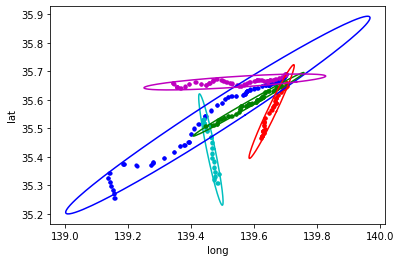

In [7]:
plt.figure()
plt.scatter(小田原線.ekiData2[:,0],小田原線.ekiData2[:,1], c="b", s=10)
plt.scatter(江ノ島線.ekiData2[:,0],江ノ島線.ekiData2[:,1], c="c", s=10)
plt.scatter(田園都市線.ekiData2[:,0],田園都市線.ekiData2[:,1], c="g", s=10)
plt.scatter(東横線.ekiData2[:,0],東横線.ekiData2[:,1], c="r", s=10)
plt.scatter(京王線.ekiData2[:,0],京王線.ekiData2[:,1], c="m", s=10)
plt.xlabel("long")
plt.ylabel("lat")
plt.plot(江ノ島線.curve_c[0],江ノ島線.curve_c[1],c="c")
plt.plot(小田原線.curve_c[0],小田原線.curve_c[1],c="b")
plt.plot(田園都市線.curve_c[0],田園都市線.curve_c[1],c="g")
plt.plot(東横線.curve_c[0],東横線.curve_c[1],c="r")
plt.plot(京王線.curve_c[0],京王線.curve_c[1],c="m")

plt.show()

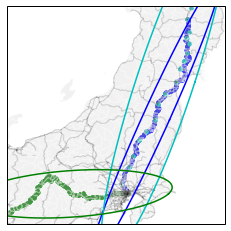

In [25]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
ax = plt.axes(projection=ccrs.PlateCarree())
# 落としてきた行政区域のshpファイルを指定
tokyo = 'N03-190101_13_GML/N03-19_13_190101.shp'
kanagawa = 'N03-190101_14_GML/N03-19_14_190101.shp'
chiba = 'N03-190101_12_GML/N03-19_12_190101.shp'
zenkoku = 'N03-190101_GML/N03-19_190101.shp'
rosen = 'N02-18_GML/N02-18_RailroadSection.shp'
eki = 'N02-18_GML/N02-18_Station.shp'
def add_geometries(fname):
    shapes = list(shpreader.Reader(fname).geometries())
    ax.add_geometries(shapes, ccrs.PlateCarree(), edgecolor='white', facecolor='lightgray', alpha=0.3)
def add_rosengeometries(fname):
    shapes = list(shpreader.Reader(fname).geometries())
    ax.add_geometries(shapes, ccrs.PlateCarree(), edgecolor='gray', facecolor='none', alpha=0.3)
def add_ekigeometries(fname):
    shapes = list(shpreader.Reader(fname).geometries())
    ax.add_geometries(shapes, ccrs.PlateCarree(), edgecolor='black',facecolor='none', alpha=0.3)
#add_geometries(chiba)
#add_geometries(kanagawa)
#add_geometries(tokyo)
add_geometries(zenkoku)
add_rosengeometries(rosen)
add_ekigeometries(eki)
# 東京あたりを描画
ax.set_extent([137, 142, 35, 40], ccrs.PlateCarree())
ax.scatter(東北線.ekiData2[:,0],東北線.ekiData2[:,1], c="b", s=10)
ax.scatter(東北新幹線.ekiData2[:,0],東北新幹線.ekiData2[:,1], c="c", s=10)
ax.scatter(中央線.ekiData2[:,0],中央線.ekiData2[:,1], c="g", s=10)
ax.plot(東北線.curve_c[0],東北線.curve_c[1],c="b")
ax.plot(東北新幹線.curve_c[0],東北新幹線.curve_c[1],c="c")
ax.plot(中央線.curve_c[0],中央線.curve_c[1],c="g")
plt.show()

In [11]:
class jikkenData():
    positions=[]
    jikkenDict=[]
    dataUrl=""
    positions2=[]
    collectEki=[]
    collectRosen=""
    ansRosen=[]
    ansEki=[]
    mahas=[]
    rosenList=["odakyu_h","odakyu_e","dento","toyoko","keio_h"]
    def __init__(self, dataUrl):
        self.positions=[]
        self.positions2=[]
        self.mahas=[]
        self.jikkenDict=[]
        self.dataUrl=dataUrl
        self.collectEki=[]
        self.collectRosen=""
        self.ansRosen=[]
        self.ansEki=[]
        self.getData()
        self.getRosenMahas()
        self.getRosen()
        self.getEki()
    def getData(self):
        with open(self.dataUrl,encoding="utf-8") as f:
            l = json.load(f)
            self.jikkenDict = l
            for i in l:
                addlist = []
                addlist.append(i.get('longitude'))
                addlist.append(i.get('latitude')) 
                self.positions.append(addlist)
            self.positions2 = np.copy(self.positions)
    def getRosenMahas(self):
        for i in self.positions:
            addlist = []
            with open('rosenmaha/rosenmaha.json',encoding="utf-8") as f:
                l = json.load(f)
                for j in l:
                    x = np.copy(i)
                    for k in range(2):
                        x[k] = x[k] - j.get("Avg")[k]
                        x[k] = x[k] / j.get("Std")[k]
                    d0 = x
                    d1 = np.dot(d0,np.array(j.get("InvR")))
                    d2 = np.dot(d1,d0)/2
                    addlist.append(d2)
            self.mahas.append(addlist)
    def getRosen(self):
        with open('rosenmaha/rosenmaha.json',encoding="utf-8") as f:
            
            l = json.load(f)                                 
            for i in self.mahas:
                addlist = []
                for j in range(len(i)):
                    if float(i[j]) < 2.48:
                        addlist2 = {}
                        addlist2["rosen"] = l[j].get("name")
                        addlist2["std"] = l[j].get("Std")
                        addlist.append(addlist2)
                addlist_sorted = sorted(addlist, key=lambda x:x['std'])
                self.ansRosen.append(addlist_sorted)
    def getEki(self):
        for i in range(len(self.positions)):
            addlist = []
            for j in self.ansRosen[i]:
                addlist2 = []
                ekiAvg=[]
                ekiStd=[]
                ekiInvR=[]
                ekiInvR2=[]
                ekiname=[]
                with open('ekimaha/'+j.get("rosen")+".json",encoding="utf-8") as f:
                    ekiAvg=[]
                    ekiStd=[]
                    ekiInvR=[]
                    ekiInvR2=[]
                    ekiname=[]
                    l = json.load(f)
                    for data in l:
                        ekiAvg.append(data.get('Avg'))
                        ekiStd.append(data.get('Std'))
                        ekiInvR2.append(data.get('InvR'))
                        ekiname.append(data.get('name'))
                    for m in range(len(ekiAvg)):
                        x = np.copy(self.positions[i])
                        for k in range(2):
                            x[k] = x[k] - ekiAvg[m][k]
                            x[k] = x[k] / ekiStd[m][k]
                        d0 = x
                        d1 = np.dot(d0,np.array(ekiInvR2[m]))
                        d2 = np.dot(d1,d0)/2
                        if d2 < 2.58:
                            addlist2.append(ekiname[m])
                    addlist.append(addlist2)
            self.ansEki.append(addlist)


In [12]:
#test0702= jikkenData("data/0702test.json")
#test0927=jikkenData("data/0927test.json")
nikotama = jikkenData("data/nikotama.json")


In [17]:
print(nikotama.ansRosen[0])

[{'rosen': '大井町線', 'std': [0.0372601157722929, 0.0025624246307164407]}, {'rosen': '田園都市線', 'std': [0.06649862919263036, 0.04215538242758329]}, {'rosen': '小田原線', 'std': [0.18268629184801233, 0.1310268697046968]}, {'rosen': '東北新幹線', 'std': [0.5547014050647361, 1.5201891992561951]}, {'rosen': '東北線', 'std': [0.5679115299241706, 1.232995847255426]}, {'rosen': '中央線', 'std': [0.8726163042278194, 0.21002926307417233]}, {'rosen': '東海道新幹線', 'std': [1.3338296432477958, 0.3096663695598278]}, {'rosen': '鋼索線', 'std': [1.4772159349907927, 0.7401231685155301]}, {'rosen': '東海道線', 'std': [1.515937090331374, 0.2898483231612046]}, {'rosen': '南北線', 'std': [1.7889483823554535, 2.796889303956934]}, {'rosen': '山手線', 'std': [1.9241886591909254, 0.42351374134477565]}, {'rosen': '本線', 'std': [2.9770489322843403, 1.3225197985245598]}]


In [14]:
print(test0702.ansRosen)

NameError: name 'test0702' is not defined

In [15]:
print(test0927.ansRosen)

NameError: name 'test0927' is not defined